In [1]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from keras.applications.vgg16 import (
    VGG16, 
    preprocess_input, 
    decode_predictions)



Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13778028858361820601
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6707519816
locality {
  bus_id: 1
}
incarnation: 3769508365413443584
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
#assigns GPU to backend (dont use this code if running off CPU)
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
#Confusion Matrix plot from scikitlearn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [328]:
#split animals folder into training, validation, and testing sets

import split_folders
split_folders.ratio('./greyscale2', output="FreshBatch", seed=1337, ratio=(.8, .1, .1))

In [380]:
#Assign Folder Paths
train_path = './split_images/train'
valid_path = './split_images/val'
test_path = './split_images/test'

gtrain_path = './grey_rgb/train'
gvalid_path = './grey_rgb/val'
gtest_path = './grey_rgb/test'

ftrain_path = './freshbatch/train'
fvalid_path = './freshbatch/val'
ftest_path = './freshbatch/test'

In [393]:
# assign batches for training and testing

train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['coyote','grey fox','kit fox','tortoise'],batch_size=391)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['coyote','grey fox','kit fox','tortoise'],batch_size=5)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['coyote','grey fox','kit fox','tortoise'],batch_size=53)

gtrain_batches = ImageDataGenerator().flow_from_directory(gtrain_path, target_size=(224,224), classes=['coyote','grey fox','kit fox','tortoise'],batch_size=979)
gvalid_batches = ImageDataGenerator().flow_from_directory(gvalid_path, target_size=(224,224), classes=['coyote','grey fox','kit fox','tortoise'],batch_size=5)
gtest_batches = ImageDataGenerator().flow_from_directory(gtest_path, target_size=(224,224), classes=['coyote','grey fox','kit fox','tortoise'],batch_size=63)

ftrain_batches = ImageDataGenerator().flow_from_directory(ftrain_path, target_size=(224,224), classes=['coyote','fox','jack rabbit'],batch_size=669)
fvalid_batches = ImageDataGenerator().flow_from_directory(fvalid_path, target_size=(224,224), classes=['coyote','fox','jack rabbit'],batch_size=83)
ftest_batches = ImageDataGenerator().flow_from_directory(ftest_path, target_size=(224,224), classes=['coyote','fox','jack rabbit'],batch_size=1)

Found 391 images belonging to 4 classes.
Found 47 images belonging to 4 classes.
Found 53 images belonging to 4 classes.
Found 979 images belonging to 4 classes.
Found 121 images belonging to 4 classes.
Found 126 images belonging to 4 classes.
Found 1294 images belonging to 3 classes.
Found 161 images belonging to 3 classes.
Found 163 images belonging to 3 classes.


In [815]:
ftest_batches.class_indices
from keras.models import load_model

model7 = Sequential()
for layer in vgg16_model.layers[:-1]:
    model7.add(layer)
    for layer in model7.layers:
        layer.trainable = False
model7.add(Dense(4, activation='softmax'))
model7.load_weights('re-trained.h5')

In [816]:
model7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [5]:
#function to plot images

def plots(ims, figsize=(12,6),rows=2, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        

c:\users\tpython\anaconda3\envs\tfgpu15\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


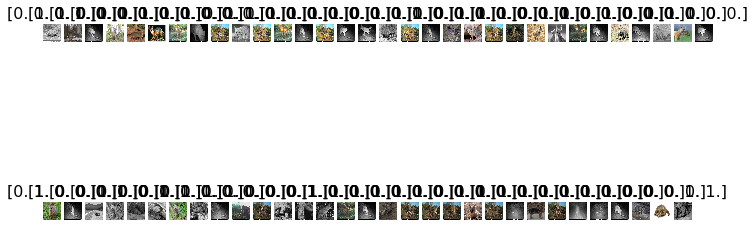

In [798]:
#Check out images
ims, labels = next(gtest_batches)
plots(ims, titles=labels)

In [367]:
#load VGG16 to train
vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [368]:
#copy VGG16 all layer except last output layer to new sequential model
model5 = Sequential()
for layer in vgg16_model.layers[:-1]:
    model5.add(layer)
    

model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [369]:
#freeze all layers but the last output layer
for layer in model5.layers:
    layer.trainable = False

In [370]:
#add  dense 4 category output layer to model for retraining
model5.add(Dense(3, activation='softmax'))


model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [371]:
# compile with adam optimizer 
#model5.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model5.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [372]:
# create datagens to flow data into fit generator/model trainer

#batch_size = 32

train_datagen = ImageDataGenerator(

            rescale=1./255,
            rotation_range=20,
            shear_range=0.2,
            channel_shift_range=0.2,
            # samplewise_center=True,
            # samplewise_std_normalization=True,
            featurewise_std_normalization=True,
            horizontal_flip=True,
            zoom_range=[0.9, 1])

# train_datagen = ImageDataGenerator(
#         rotation_range=50,
#         shear_range=0.2,
#         channel_shift_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         )

test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
        './freshbatch/val',
        color_mode = 'rgb',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')


train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            shear_range=0.2,
            channel_shift_range=0.2,
            # samplewise_center=True,
            # samplewise_std_normalization=True,
            featurewise_std_normalization=True,
            horizontal_flip=True,
            zoom_range=[0.9, 1])

train_generator = train_datagen.flow_from_directory(
        './freshbatch/train',  # this is the target directory
        color_mode = 'rgb',
        target_size=(224, 224),  # all images will be resized to 299x299
        batch_size=32,
        class_mode='categorical')

#steps_per_epoch = train_generator.n//train_generator.batch_size

batch_size = train_generator.batch_size
n_total = train_generator.n

def calc_n_batches_per_epoch(n_total, batch_size, drop_remainder=True):
    # Calculate n batches per epoch 
    n_batches_per_epoch = n_total // batch_size
    remainder = np.min([n_total % batch_size, 1])

    if not drop_remainder:
        n_batches_per_epoch += remainder

    return int(n_batches_per_epoch)

calc_n_batches_per_epoch(n_total, batch_size, drop_remainder=True)

Found 161 images belonging to 3 classes.
Found 1294 images belonging to 3 classes.


40

In [253]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

ftrain_batches

In [373]:
#fit the model

model5.fit_generator(train_generator, steps_per_epoch=1294, validation_data=validation_generator, epochs=10, verbose=2 )

Epoch 1/10
 - 426s - loss: 0.7178 - acc: 0.7166 - val_loss: 0.6177 - val_acc: 0.7516
Epoch 2/10
 - 423s - loss: 0.5661 - acc: 0.7914 - val_loss: 0.5025 - val_acc: 0.8137
Epoch 3/10
 - 452s - loss: 0.5172 - acc: 0.8103 - val_loss: 0.4872 - val_acc: 0.8385
Epoch 4/10
 - 425s - loss: 0.4878 - acc: 0.8200 - val_loss: 0.4765 - val_acc: 0.8509
Epoch 5/10
 - 428s - loss: 0.4713 - acc: 0.8256 - val_loss: 0.4962 - val_acc: 0.8385
Epoch 6/10
 - 428s - loss: 0.4548 - acc: 0.8327 - val_loss: 0.4354 - val_acc: 0.8385
Epoch 7/10
 - 419s - loss: 0.4393 - acc: 0.8377 - val_loss: 0.4354 - val_acc: 0.8447
Epoch 8/10
 - 417s - loss: 0.4320 - acc: 0.8428 - val_loss: 0.4244 - val_acc: 0.8634
Epoch 9/10
 - 422s - loss: 0.4205 - acc: 0.8450 - val_loss: 0.4268 - val_acc: 0.8385
Epoch 10/10
 - 420s - loss: 0.4126 - acc: 0.8501 - val_loss: 0.4139 - val_acc: 0.8509


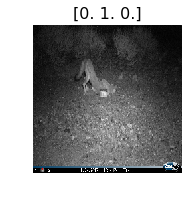

In [469]:
#Check out images
ims, labels = next(ftest_batches)
plots(ims, titles=labels)

1/1 [==============================] - 0s 31ms/step
Confusion matrix, without normalization
[[0 0]
 [1 0]]


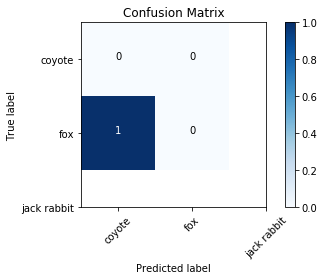

In [470]:
predictions5 = model5.predict_generator(ftest_batches, steps=1, verbose=1)
cm = confusion_matrix(labels.argmax(axis=1), predictions5.argmax(axis=1))
cm_plot_labels = ['coyote','fox','jack rabbit']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [400]:
#crteate classification report to display results on test batch predictions
from sklearn.metrics import classification_report
y_true = labels.argmax(axis=1)
y_pred = predictions5.argmax(axis=1)
target_names = ['coyote', 'fox', 'jack rabbit']
print(classification_report(y_true, y_pred, target_names=target_names))

ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

In [485]:
predictionz = model5.predict_generator(ftest_batches,steps=1)

label = predictionz.argmax(axis=1)[0]

In [489]:
predictionz = model5.predict_generator(ftest_batches,steps=1)
label = predictionz.argmax(axis=1)[0]
if label == 0:
    print('Coyote'),
elif label == 1:
    print('fox'),
elif label == 2:
    print('jack rabbit')

jack_rabbit


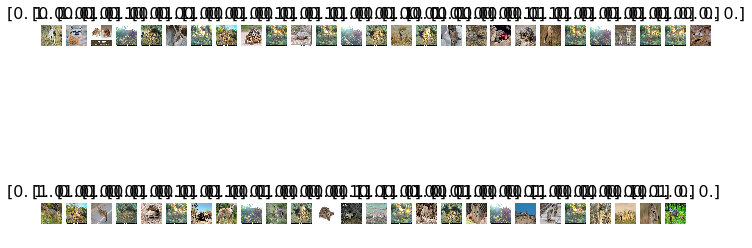

In [70]:
#assign test images to test batch and display
test_ims, test_labels = next(test_batches)
plots(test_ims, titles=test_labels)

1/1 [==============================] - 0s 469ms/step
Confusion matrix, without normalization
[[26  1  0  0]
 [ 2  8  1  0]
 [ 1  3  3  0]
 [ 0  0  0  8]]


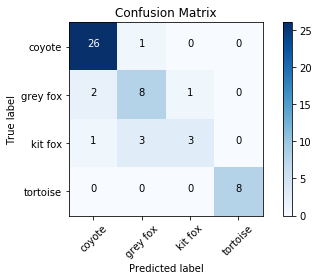

In [71]:
#create confusion matrix to display results
predictions = model2.predict_generator(test_batches, steps=1, verbose=1)
cm = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))
cm_plot_labels = ['coyote', 'grey fox','kit fox', 'tortoise']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [72]:
#crteate classification report to display results on test batch predictions
from sklearn.metrics import classification_report
y_true = test_labels.argmax(axis=1)
y_pred = predictions.argmax(axis=1)
target_names = ['coyote', 'grey fox','kit fox', 'tortoise']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      coyote       0.90      0.96      0.93        27
    grey fox       0.67      0.73      0.70        11
     kit fox       0.75      0.43      0.55         7
    tortoise       1.00      1.00      1.00         8

   micro avg       0.85      0.85      0.85        53
   macro avg       0.83      0.78      0.79        53
weighted avg       0.85      0.85      0.84        53



In [283]:
model.save_weights('Re-trained2.h5')

In [50]:
#now try to retrain inceptionV3 model
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 4 classes
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model1 = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
    
batch_size = 16

#assign training,testing, and validation generators
train_datagen1 = ImageDataGenerator(
        rotation_range=20,
        shear_range=0.2,
        channel_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        )

test_datagen1 = ImageDataGenerator(rescale=1./255)

validation_generator1 = test_datagen1.flow_from_directory(
        valid_path,
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='categorical')



train_generator1 = train_datagen1.flow_from_directory(
        './split_images/train',  # this is the target directory
        target_size=(299, 299),  # all images will be resized to 299x299
        batch_size=batch_size,
        class_mode='categorical')
    

steps_per_epoch = train_generator1.n//train_generator1.batch_size

Found 47 images belonging to 4 classes.
Found 391 images belonging to 4 classes.


In [51]:

# compile the model (should be done *after* setting layers to non-trainable)
model1.compile(optimizer='Adam', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
model1.fit_generator(train_generator1, steps_per_epoch=steps_per_epoch, validation_data=validation_generator1, epochs=5, verbose=2 )


# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

Epoch 1/5
 - 8s - loss: 1.1353 - val_loss: 0.3747
Epoch 2/5
 - 7s - loss: 0.5220 - val_loss: 0.1619
Epoch 3/5
 - 7s - loss: 0.2734 - val_loss: 0.3731
Epoch 4/5
 - 7s - loss: 0.3833 - val_loss: 0.2011
Epoch 5/5
 - 7s - loss: 0.3126 - val_loss: 0.2258


In [46]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model1.layers[:249]:
   layer.trainable = False
for layer in model1.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use adam with a low learning rate

model1.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model1.fit_generator(train_generator1, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, epochs=20, verbose=2 )


0 input_4
1 conv2d_189
2 batch_normalization_189
3 activation_189
4 conv2d_190
5 batch_normalization_190
6 activation_190
7 conv2d_191
8 batch_normalization_191
9 activation_191
10 max_pooling2d_9
11 conv2d_192
12 batch_normalization_192
13 activation_192
14 conv2d_193
15 batch_normalization_193
16 activation_193
17 max_pooling2d_10
18 conv2d_197
19 batch_normalization_197
20 activation_197
21 conv2d_195
22 conv2d_198
23 batch_normalization_195
24 batch_normalization_198
25 activation_195
26 activation_198
27 average_pooling2d_19
28 conv2d_194
29 conv2d_196
30 conv2d_199
31 conv2d_200
32 batch_normalization_194
33 batch_normalization_196
34 batch_normalization_199
35 batch_normalization_200
36 activation_194
37 activation_196
38 activation_199
39 activation_200
40 mixed0
41 conv2d_204
42 batch_normalization_204
43 activation_204
44 conv2d_202
45 conv2d_205
46 batch_normalization_202
47 batch_normalization_205
48 activation_202
49 activation_205
50 average_pooling2d_20
51 conv2d_201
52 

1/1 [==============================] - 2s 2s/step
Confusion matrix, without normalization
[[27  0  0  0]
 [11  0  0  0]
 [ 7  0  0  0]
 [ 8  0  0  0]]


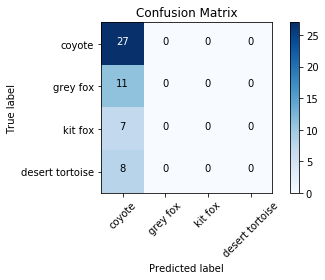

In [52]:
predictions2 = model1.predict_generator(test_batches, steps=1, verbose=1)
cm = confusion_matrix(test_labels.argmax(axis=1), predictions2.argmax(axis=1))
cm_plot_labels = ['coyote','grey fox','kit fox','desert tortoise']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')


In [53]:
v3y_true = test_labels.argmax(axis=1)
v3y_pred = predictions2.argmax(axis=1)
target_names = ['coyote', 'grey fox','kit fox', 'tortoise']
print(classification_report(v3y_true, v3y_pred, target_names=target_names))

              precision    recall  f1-score   support

      coyote       0.51      1.00      0.67        27
    grey fox       0.00      0.00      0.00        11
     kit fox       0.00      0.00      0.00         7
    tortoise       0.00      0.00      0.00         8

   micro avg       0.51      0.51      0.51        53
   macro avg       0.13      0.25      0.17        53
weighted avg       0.26      0.51      0.34        53



In [ ]:
model1.save_weights('terrible_model.h5')

In [200]:
date = exif['DateTimeOriginal']

In [201]:
date

'2016:02:01 23:37:53'

In [ ]:
ftest_batches = ImageDataGenerator().flow_from_directory(ftest_path, target_size=(224,224), classes=['coyote','fox','jack rabbit'],batch_size=50)
predictions2 = model1.predict_generator(test_batches, steps=1, verbose=1)

In [ ]:
predictionz = model5.predict_generator(ftest_batches,steps=1)
label = predictionz.argmax(axis=1)[0]

def prediction_label(label)
if label == 0:
    print('Coyote'),
elif label == 1:
    print('fox'),
elif label == 2:
    print('jack rabbit')

In [604]:
import exifread
# Open image file for reading (binary mode)
path = './FreshBatch/test/coyote/coyote (1054).jpg'

f = open(path, 'rb')
# Return Exif tags
tags = exifread.process_file(f, stop_tag='EXIF')
#tags = exifread.process_file(f)
x = {}
for tag in tags.keys():

    #print ("Key: %s, value %s" % (tag, tags[tag]))
    #x[tag] = [tag[tags]]
    if tag not in ('JPEGThumbnail', 'TIFFThumbnail', 'Filename', 'EXIF MakerNote'):
      
        x[tag] = [tags[tag]]


In [626]:
x['EXIF DateTimeOriginal'][0]
comments = str(x['EXIF UserComment'])
ID= str(myList[0]).split(',')
CAM_ID = ID[14].split('=')[1]
CAM_ID

'417'

In [914]:
path = './master'

folder = os.fsencode(path)

filenames = []

for file in os.listdir(folder):
    filename = os.fsdecode(file)

    if filename.endswith( ( '.JPG', '.jpg') ): # whatever file types you're using...
        filenames.append(path +'/'+ filename)

In [915]:
filenames[:10]

['./master/master (1).JPG',
 './master/master (10).JPG',
 './master/master (100).JPG',
 './master/master (1000).JPG',
 './master/master (1001).JPG',
 './master/master (1002).JPG',
 './master/master (1003).JPG',
 './master/master (1004).JPG',
 './master/master (1005).JPG',
 './master/master (1006).JPG']

In [964]:
wow = []
whacklist = ['5sec', '5min', 'FAP']
import pandas as pd


for filename in filenames:
    path = filename
    f = open(path, 'rb')
        # Return Exif tags
    tags = exifread.process_file(f)
        #tags = exifread.process_file(f)
    cam = {}
    CAM_ID = []
    DATETIME = []
    IMG = []
    x = {}
    print(path)
    for tag in tags.keys():
    
        #print ("Key: %s, value %s" % (tag, tags[tag]))
        
        #if tag not in ('JPEGThumbnail', 'TIFFThumbnail', 'Filename'):
      
        x[tag] = [tags[tag]]
    
              
            
    try:       #dt = x['Image DateTime']
        date = str(x['EXIF DateTimeOriginal'])
        datetime = date.split('=')[1].split('@')[0]
        cam['DATETIME'] = datetime
        comments = str(x['EXIF UserComment'])
        print(comments)
        ID= str(comments).split(',')
        CAM_ID = ID[14].split('=')[1]
        print(CAM_ID)
        if CAM_ID not in whacklist:
            cam['CAM_ID'] = CAM_ID
        if CAM_ID in whacklist:
            CAM_ID = ID[12].split('=')[1]
            cam['CAM_ID'] = CAM_ID
        cam['IMG'] = path
        print(path)
        wow.append(cam)
    except:
         print('error')
       



./master/master (1).JPG
[(0x9286) ASCII=2015,LD=136,BT=10,RD=130,LH=0,LI=129,BL=5254,BP=50%,BD=135,BI=767,CF=Disabled,IR=40%,WL=850nm,EX=Wide,ID=406,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
406
./master/master (1).JPG
./master/master (10).JPG
[(0x9286) ASCII=2015,LD=130,BT=10,RD=124,LH=0,LI=117,BL=5345,BP=75%,BD=130,BI=647,CF=Disabled,IR=50%,WL=850nm,EX=Wide,ID=406,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
406
./master/master (10).JPG
./master/master (100).JPG
[(0x9286) ASCII=2015,LD=132,BT=9,RD=127,LH=0,LI=255,BL=5221,BP=50%,BD=132,BI=2331,CF=Disabled,IR=50%,WL=850nm,EX=Wide,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
426
./master/master (100).JPG
./master/master (1000).JPG
[(0x9286) ASCII=2015,LD=134,BT=11,RD=128,LH=0,LI=331,BL=5109,BP=50%,BD=134,BI=2370,CF=Disabled,IR=40%,WL=850nm,EX=Wide,ID=417,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
417
./master/master (1000).JPG
./maste

./master/master (1126).JPG
[(0x9286) ASCII=2015,LD=59,BT=15,RD=53,LH=0,LI=145,BL=5491,BP=75%,BD=59,BI=1362,CF=Disabled,IR=80%,WL=850nm,EX=Wide,ID=449,SM=ADV,DD=5min,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
449
./master/master (1126).JPG
./master/master (1127).JPG
[(0x9286) ASCII=2015,LD=59,BT=15,RD=53,LH=0,LI=145,BL=5491,BP=75%,BD=59,BI=1367,CF=Disabled,IR=80%,WL=850nm,EX=Wide,ID=449,SM=ADV,DD=5min,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
449
./master/master (1127).JPG
./master/master (1128).JPG
[(0x9286) ASCII=2015,LD=59,BT=15,RD=53,LH=0,LI=146,BL=5495,BP=75%,BD=59,BI=1372,CF=Disabled,IR=80%,WL=850nm,EX=Wide,ID=449,SM=ADV,DD=5min,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
449
./master/master (1128).JPG
./master/master (1129).JPG
[(0x9286) ASCII=2015,LD=59,BT=15,RD=53,LH=0,LI=146,BL=5495,BP=75%,BD=59,BI=1377,CF=Disabled,IR=80%,WL=850nm,EX=Wide,ID=449,SM=ADV,DD=5min,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
449
./master/master (1129).JPG
./ma

./master/master (1258).JPG
[(0x9286) ASCII=2015,LD=59,BT=15,RD=53,LH=0,LI=211,BL=5440,BP=75%,BD=59,BI=2022,CF=Disabled,IR=80%,WL=850nm,EX=Wide,ID=449,SM=ADV,DD=5min,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
449
./master/master (1258).JPG
./master/master (1259).JPG
[(0x9286) ASCII=2015,LD=59,BT=15,RD=53,LH=0,LI=211,BL=5440,BP=75%,BD=59,BI=2027,CF=Disabled,IR=80%,WL=850nm,EX=Wide,ID=449,SM=ADV,DD=5min,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
449
./master/master (1259).JPG
./master/master (126).JPG
[(0x9286) ASCII=2015,LD=132,BT=9,RD=127,LH=0,LI=268,BL=5216,BP=50%,BD=132,BI=2461,CF=Disabled,IR=50%,WL=850nm,EX=Wide,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
426
./master/master (126).JPG
./master/master (1260).JPG
[(0x9286) ASCII=2015,LD=59,BT=15,RD=53,LH=0,LI=212,BL=5437,BP=75%,BD=59,BI=2032,CF=Disabled,IR=80%,WL=850nm,EX=Wide,ID=449,SM=ADV,DD=5min,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
449
./master/master (1260).JPG
./ma

./master/master (1315).JPG
[(0x9286) ASCII=2015,LD=209,BT=9,RD=204,LH=0,LI=193,BL=5087,BP=50%,BD=209,BI=1671,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=422,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
422
./master/master (1315).JPG
./master/master (1316).JPG
[(0x9286) ASCII=2015,LD=210,BT=9,RD=205,LH=0,LI=194,BL=5102,BP=50%,BD=210,BI=1676,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=422,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
422
./master/master (1316).JPG
./master/master (1317).JPG
[(0x9286) ASCII=2015,LD=210,BT=9,RD=205,LH=0,LI=194,BL=5102,BP=50%,BD=210,BI=1681,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=422,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
422
./master/master (1317).JPG
./master/master (1318).JPG
[(0x9286) ASCII=2015,LD=212,BT=9,RD=207,LH=0,LI=195,BL=5100,BP=50%,BD=211,BI=1686,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=422,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
422
./master/master (1318).

./master/master (1381).JPG
[(0x9286) ASCII=2015,LD=270,BT=9,RD=265,LH=0,LI=227,BL=4868,BP=25%,BD=269,BI=1886,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=422,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
422
./master/master (1381).JPG
./master/master (1382).JPG
[(0x9286) ASCII=2015,LD=270,BT=9,RD=265,LH=0,LI=227,BL=4868,BP=25%,BD=269,BI=1891,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=422,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
422
./master/master (1382).JPG
./master/master (1383).JPG
[(0x9286) ASCII=2015,LD=275,BT=9,RD=270,LH=0,LI=228,BL=4909,BP=25%,BD=274,BI=1896,CF=Enabled,EX=Centered,ID=422,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (1383).JPG
./master/master (1384).JPG
[(0x9286) ASCII=2015,LD=275,BT=9,RD=270,LH=0,LI=228,BL=4909,BP=25%,BD=274,BI=1897,CF=Enabled,EX=Centered,ID=422,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (1384).JPG
./master/master (138

./master/master (1463).JPG
[(0x9286) ASCII=2015,LD=135,BT=11,RD=129,LH=0,LI=218,BL=5269,BP=50%,BD=135,BI=1804,CF=Disabled,IR=50%,WL=850nm,EX=Wide,ID=416,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
416
./master/master (1463).JPG
./master/master (1464).JPG
[(0x9286) ASCII=2015,LD=135,BT=11,RD=129,LH=0,LI=218,BL=5269,BP=50%,BD=135,BI=1809,CF=Disabled,IR=50%,WL=850nm,EX=Wide,ID=416,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
416
./master/master (1464).JPG
./master/master (1465).JPG
[(0x9286) ASCII=2015,LD=135,BT=11,RD=129,LH=0,LI=219,BL=5248,BP=50%,BD=135,BI=1814,CF=Disabled,IR=50%,WL=850nm,EX=Wide,ID=416,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
416
./master/master (1465).JPG
./master/master (1466).JPG
[(0x9286) ASCII=2015,LD=135,BT=11,RD=129,LH=0,LI=219,BL=5248,BP=50%,BD=135,BI=1819,CF=Disabled,IR=50%,WL=850nm,EX=Wide,ID=416,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
416
./master/master (14

./master/master (1544).JPG
[(0x9286) ASCII=2015,LD=164,BT=11,RD=158,LH=0,LI=258,BL=5268,BP=50%,BD=164,BI=2209,CF=Disabled,IR=40%,WL=850nm,EX=Wide,ID=416,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
416
./master/master (1544).JPG
./master/master (1545).JPG
[(0x9286) ASCII=2015,LD=165,BT=11,RD=159,LH=0,LI=259,BL=5247,BP=50%,BD=164,BI=2214,CF=Disabled,IR=40%,WL=850nm,EX=Wide,ID=416,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
416
./master/master (1545).JPG
./master/master (1546).JPG
[(0x9286) ASCII=2015,LD=165,BT=11,RD=159,LH=0,LI=259,BL=5247,BP=50%,BD=164,BI=2219,CF=Disabled,IR=40%,WL=850nm,EX=Wide,ID=416,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
416
./master/master (1546).JPG
./master/master (1547).JPG
[(0x9286) ASCII=2015,LD=166,BT=11,RD=160,LH=0,LI=260,BL=5253,BP=50%,BD=165,BI=2224,CF=Disabled,IR=32%,WL=850nm,EX=Wide,ID=416,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
416
./master/master (15

./master/master (1612).JPG
[(0x9286) ASCII=2015,LD=137,BT=11,RD=129,LH=0,LI=238,BL=5242,BP=50%,BD=137,BI=2156,CF=Disabled,IR=40%,WL=850nm,EX=Wide,ID=414,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
414
./master/master (1612).JPG
./master/master (1613).JPG
[(0x9286) ASCII=2015,LD=137,BT=11,RD=129,LH=0,LI=238,BL=5242,BP=50%,BD=137,BI=2161,CF=Disabled,IR=40%,WL=850nm,EX=Wide,ID=414,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
414
./master/master (1613).JPG
./master/master (1614).JPG
[(0x9286) ASCII=2015,LD=137,BT=11,RD=129,LH=0,LI=239,BL=5241,BP=50%,BD=137,BI=2166,CF=Disabled,IR=40%,WL=850nm,EX=Wide,ID=414,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
414
./master/master (1614).JPG
./master/master (1615).JPG
[(0x9286) ASCII=2015,LD=137,BT=11,RD=129,LH=0,LI=239,BL=5241,BP=50%,BD=137,BI=2171,CF=Disabled,IR=40%,WL=850nm,EX=Wide,ID=414,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
414
./master/master (16

./master/master (1662).JPG
[(0x9286) ASCII=2015,LD=146,BT=11,RD=138,LH=0,LI=263,BL=5275,BP=50%,BD=145,BI=2406,CF=Disabled,IR=40%,WL=850nm,EX=Wide,ID=414,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
414
./master/master (1662).JPG
./master/master (1663).JPG
[(0x9286) ASCII=2015,LD=146,BT=11,RD=138,LH=0,LI=263,BL=5275,BP=50%,BD=145,BI=2411,CF=Disabled,IR=40%,WL=850nm,EX=Wide,ID=414,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
414
./master/master (1663).JPG
./master/master (1664).JPG
[(0x9286) ASCII=2015,LD=146,BT=11,RD=138,LH=0,LI=264,BL=5251,BP=50%,BD=145,BI=2416,CF=Disabled,IR=40%,WL=850nm,EX=Wide,ID=414,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
414
./master/master (1664).JPG
./master/master (1665).JPG
[(0x9286) ASCII=2015,LD=146,BT=11,RD=138,LH=0,LI=264,BL=5251,BP=50%,BD=145,BI=2421,CF=Disabled,IR=40%,WL=850nm,EX=Wide,ID=414,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
414
./master/master (16

./master/master (1742).JPG
[(0x9286) ASCII=2015,LD=163,BT=11,RD=155,LH=0,LI=303,BL=5131,BP=50%,BD=163,BI=2779,CF=Disabled,IR=32%,WL=850nm,EX=Wide,ID=414,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
414
./master/master (1742).JPG
./master/master (1743).JPG
[(0x9286) ASCII=2015,LD=163,BT=11,RD=155,LH=0,LI=304,BL=5115,BP=50%,BD=163,BI=2784,CF=Disabled,IR=32%,WL=850nm,EX=Wide,ID=414,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
414
./master/master (1743).JPG
./master/master (1744).JPG
[(0x9286) ASCII=2015,LD=163,BT=11,RD=155,LH=0,LI=304,BL=5115,BP=50%,BD=163,BI=2789,CF=Disabled,IR=32%,WL=850nm,EX=Wide,ID=414,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
414
./master/master (1744).JPG
./master/master (1745).JPG
[(0x9286) ASCII=2015,LD=163,BT=11,RD=155,LH=0,LI=305,BL=5107,BP=50%,BD=163,BI=2794,CF=Disabled,IR=32%,WL=850nm,EX=Wide,ID=414,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
414
./master/master (17

./master/master (1816).JPG
./master/master (1817).JPG
[(0x9286) ASCII=2015,LD=174,BT=12,RD=166,LH=0,LI=339,BL=5189,BP=50%,BD=10,BI=75,CF=Disabled,IR=32%,WL=850nm,EX=Wide,ID=414,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
414
./master/master (1817).JPG
./master/master (1818).JPG
[(0x9286) ASCII=2015,LD=176,BT=12,RD=168,LH=0,LI=340,BL=5176,BP=50%,BD=11,BI=80,CF=Disabled,IR=32%,WL=850nm,EX=Wide,ID=414,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
414
./master/master (1818).JPG
./master/master (1819).JPG
[(0x9286) ASCII=2015,LD=176,BT=12,RD=168,LH=0,LI=340,BL=5176,BP=50%,BD=11,BI=85,CF=Disabled,IR=32%,WL=850nm,EX=Wide,ID=414,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
414
./master/master (1819).JPG
./master/master (182).JPG
[(0x9286) ASCII=2015,LD=133,BT=9,RD=128,LH=0,LI=296,BL=5194,BP=50%,BD=133,BI=2741,CF=Disabled,IR=50%,WL=850nm,EX=Wide,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
426
./m

./master/master (1895).JPG
[(0x9286) ASCII=2015,LD=191,BT=10,RD=131,LH=0,LI=438,BL=5112,BP=50%,BD=190,BI=1946,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
405
./master/master (1895).JPG
./master/master (1896).JPG
[(0x9286) ASCII=2015,LD=191,BT=10,RD=131,LH=0,LI=439,BL=5151,BP=50%,BD=191,BI=1951,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
405
./master/master (1896).JPG
./master/master (1897).JPG
[(0x9286) ASCII=2015,LD=191,BT=10,RD=131,LH=0,LI=439,BL=5151,BP=50%,BD=191,BI=1956,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
405
./master/master (1897).JPG
./master/master (1898).JPG
[(0x9286) ASCII=2015,LD=193,BT=10,RD=133,LH=0,LI=440,BL=5137,BP=50%,BD=192,BI=1961,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
405
./master/master (18

./master/master (1990).JPG
[(0x9286) ASCII=2015,LD=206,BT=10,RD=146,LH=0,LI=486,BL=5105,BP=50%,BD=206,BI=2349,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
405
./master/master (1990).JPG
./master/master (1991).JPG
[(0x9286) ASCII=2015,LD=206,BT=10,RD=146,LH=0,LI=486,BL=5105,BP=50%,BD=206,BI=2354,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
405
./master/master (1991).JPG
./master/master (1992).JPG
[(0x9286) ASCII=2015,LD=206,BT=10,RD=146,LH=0,LI=487,BL=5082,BP=50%,BD=206,BI=2359,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
405
./master/master (1992).JPG
./master/master (1993).JPG
[(0x9286) ASCII=2015,LD=206,BT=10,RD=146,LH=0,LI=487,BL=5082,BP=50%,BD=206,BI=2364,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
405
./master/master (19

./master/master (2081).JPG
./master/master (2082).JPG
[(0x9286) ASCII=2015,LD=209,BT=10,RD=149,LH=0,LI=531,BL=5073,BP=50%,BD=208,BI=2804,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
405
./master/master (2082).JPG
./master/master (2083).JPG
[(0x9286) ASCII=2015,LD=209,BT=10,RD=149,LH=0,LI=532,BL=5021,BP=50%,BD=208,BI=2809,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
405
./master/master (2083).JPG
./master/master (2084).JPG
[(0x9286) ASCII=2015,LD=209,BT=10,RD=149,LH=0,LI=532,BL=5021,BP=50%,BD=208,BI=2814,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
405
./master/master (2084).JPG
./master/master (2085).JPG
[(0x9286) ASCII=2015,LD=209,BT=10,RD=149,LH=0,LI=533,BL=5069,BP=50%,BD=208,BI=2819,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 4

./master/master (218).JPG
[(0x9286) ASCII=2015,LD=159,BT=9,RD=154,LH=0,LI=314,BL=5202,BP=50%,BD=158,BI=2921,CF=Disabled,IR=32%,WL=850nm,EX=Wide,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
426
./master/master (218).JPG
./master/master (2180).JPG
[(0x9286) ASCII=2015,LD=234,BT=10,RD=174,LH=0,LI=580,BL=5046,BP=50%,BD=233,BI=3262,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
405
./master/master (2180).JPG
./master/master (2181).JPG
[(0x9286) ASCII=2015,LD=234,BT=10,RD=174,LH=0,LI=581,BL=5073,BP=50%,BD=234,BI=3267,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
405
./master/master (2181).JPG
./master/master (2182).JPG
[(0x9286) ASCII=2015,LD=234,BT=10,RD=174,LH=0,LI=581,BL=5073,BP=50%,BD=234,BI=3272,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
405
./master/master (2182)

./master/master (2284).JPG
[(0x9286) ASCII=2015,LD=244,BT=10,RD=184,LH=0,LI=625,BL=4957,BP=25%,BD=243,BI=3616,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
405
./master/master (2284).JPG
./master/master (2285).JPG
[(0x9286) ASCII=2015,LD=397,BT=14,RD=298,LH=0,LI=921,BL=5559,BP=75%,BD=77,BI=3097,CF=Disabled,IR=100%,WL=850nm,EX=Wide,ID=414,SM=ADV,DD=FAP,DI=2,DV=OFF,DL=OFF,ND=FAP,NI=2,NV=OFF,NL=OFF @ 464]
414
./master/master (2285).JPG
./master/master (2286).JPG
[(0x9286) ASCII=2015,LD=244,BT=10,RD=184,LH=0,LI=626,BL=4961,BP=25%,BD=243,BI=3621,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
405
./master/master (2286).JPG
./master/master (2287).JPG
[(0x9286) ASCII=2015,LD=397,BT=14,RD=298,LH=0,LI=921,BL=5559,BP=75%,BD=77,BI=3102,CF=Disabled,IR=100%,WL=850nm,EX=Wide,ID=414,SM=ADV,DD=FAP,DI=2,DV=OFF,DL=OFF,ND=FAP,NI=2,NV=OFF,NL=OFF @ 464]
414
./master/master (2287).

./master/master (236).JPG
[(0x9286) ASCII=2015,LD=170,BT=9,RD=165,LH=0,LI=323,BL=5148,BP=50%,BD=170,BI=3011,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
426
./master/master (236).JPG
./master/master (237).JPG
[(0x9286) ASCII=2015,LD=175,BT=9,RD=170,LH=0,LI=324,BL=5138,BP=50%,BD=174,BI=3016,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
426
./master/master (237).JPG
./master/master (238).JPG
[(0x9286) ASCII=2015,LD=175,BT=9,RD=170,LH=0,LI=324,BL=5138,BP=50%,BD=174,BI=3021,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
426
./master/master (238).JPG
./master/master (239).JPG
[(0x9286) ASCII=2015,LD=181,BT=9,RD=176,LH=0,LI=325,BL=5138,BP=50%,BD=180,BI=3026,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
426
./master/master (239).JPG
./ma

./master/master (292).JPG
[(0x9286) ASCII=2015,LD=559,BT=13,RD=474,LH=0,LI=459,BL=5692,BP=90%,BD=8,BI=176,CF=Disabled,IR=125%,WL=850nm,EX=Wide,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
426
./master/master (292).JPG
./master/master (293).JPG
[(0x9286) ASCII=2015,LD=559,BT=13,RD=474,LH=0,LI=459,BL=5692,BP=90%,BD=8,BI=181,CF=Disabled,IR=125%,WL=850nm,EX=Wide,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
426
./master/master (293).JPG
./master/master (294).JPG
[(0x9286) ASCII=2015,LD=559,BT=13,RD=474,LH=0,LI=460,BL=5686,BP=90%,BD=8,BI=186,CF=Disabled,IR=125%,WL=850nm,EX=Wide,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
426
./master/master (294).JPG
./master/master (295).JPG
[(0x9286) ASCII=2015,LD=559,BT=13,RD=474,LH=0,LI=460,BL=5686,BP=90%,BD=8,BI=191,CF=Disabled,IR=125%,WL=850nm,EX=Wide,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
426
./master/master (295).JPG
./master

./master/master (347).JPG
[(0x9286) ASCII=2015,LD=560,BT=13,RD=475,LH=0,LI=486,BL=5689,BP=90%,BD=8,BI=311,CF=Enabled,EX=Centered,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (347).JPG
./master/master (348).JPG
[(0x9286) ASCII=2015,LD=560,BT=13,RD=475,LH=0,LI=487,BL=5691,BP=90%,BD=8,BI=312,CF=Enabled,EX=Centered,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (348).JPG
./master/master (349).JPG
[(0x9286) ASCII=2015,LD=560,BT=13,RD=475,LH=0,LI=487,BL=5691,BP=90%,BD=8,BI=313,CF=Enabled,EX=Centered,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (349).JPG
./master/master (35).JPG
[(0x9286) ASCII=2015,LD=130,BT=9,RD=125,LH=0,LI=223,BL=5316,BP=75%,BD=129,BI=2078,CF=Enabled,EX=Centered,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (35).JPG
./master/master (350).JPG
[(0x9286) ASCII=2015,LD=560,BT=13,

5sec
./master/master (409).JPG
./master/master (41).JPG
[(0x9286) ASCII=2015,LD=130,BT=9,RD=125,LH=0,LI=226,BL=5304,BP=75%,BD=129,BI=2084,CF=Enabled,EX=Centered,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (41).JPG
./master/master (410).JPG
[(0x9286) ASCII=2015,LD=565,BT=13,RD=480,LH=0,LI=518,BL=5596,BP=75%,BD=13,BI=415,CF=Enabled,EX=Centered,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (410).JPG
./master/master (411).JPG
[(0x9286) ASCII=2015,LD=565,BT=13,RD=480,LH=0,LI=519,BL=5599,BP=75%,BD=13,BI=416,CF=Enabled,EX=Centered,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (411).JPG
./master/master (412).JPG
[(0x9286) ASCII=2015,LD=565,BT=13,RD=480,LH=0,LI=519,BL=5599,BP=75%,BD=13,BI=417,CF=Enabled,EX=Centered,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (412).JPG
./master/master (413).JPG


./master/master (46).JPG
[(0x9286) ASCII=2015,LD=130,BT=9,RD=125,LH=0,LI=228,BL=5282,BP=50%,BD=129,BI=2089,CF=Enabled,EX=Centered,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (46).JPG
./master/master (460).JPG
[(0x9286) ASCII=2015,LD=565,BT=13,RD=480,LH=0,LI=543,BL=5611,BP=90%,BD=13,BI=465,CF=Enabled,EX=Centered,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (460).JPG
./master/master (461).JPG
[(0x9286) ASCII=2015,LD=565,BT=13,RD=480,LH=0,LI=544,BL=5619,BP=90%,BD=13,BI=466,CF=Enabled,EX=Centered,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (461).JPG
./master/master (462).JPG
[(0x9286) ASCII=2015,LD=565,BT=13,RD=480,LH=0,LI=544,BL=5619,BP=90%,BD=13,BI=467,CF=Enabled,EX=Centered,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (462).JPG
./master/master (463).JPG
[(0x9286) ASCII=2015,LD=565,BT=

./master/master (512).JPG
[(0x9286) ASCII=2015,LD=143,BT=11,RD=136,LH=0,LI=274,BL=5241,BP=50%,BD=142,BI=2100,CF=Disabled,IR=32%,WL=850nm,EX=Wide,ID=403,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
403
./master/master (512).JPG
./master/master (513).JPG
[(0x9286) ASCII=2015,LD=143,BT=11,RD=136,LH=0,LI=274,BL=5241,BP=50%,BD=142,BI=2105,CF=Disabled,IR=32%,WL=850nm,EX=Wide,ID=403,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
403
./master/master (513).JPG
./master/master (514).JPG
[(0x9286) ASCII=2015,LD=143,BT=11,RD=136,LH=0,LI=275,BL=5215,BP=50%,BD=142,BI=2110,CF=Disabled,IR=32%,WL=850nm,EX=Wide,ID=403,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
403
./master/master (514).JPG
./master/master (515).JPG
[(0x9286) ASCII=2015,LD=143,BT=11,RD=136,LH=0,LI=275,BL=5215,BP=50%,BD=142,BI=2115,CF=Disabled,IR=32%,WL=850nm,EX=Wide,ID=403,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
403
./master/master (515).JPG


./master/master (558).JPG
[(0x9286) ASCII=2015,LD=149,BT=11,RD=142,LH=0,LI=297,BL=5280,BP=50%,BD=148,BI=2290,CF=Enabled,EX=Centered,ID=403,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (558).JPG
./master/master (559).JPG
[(0x9286) ASCII=2015,LD=149,BT=11,RD=142,LH=0,LI=297,BL=5280,BP=50%,BD=148,BI=2291,CF=Enabled,EX=Centered,ID=403,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (559).JPG
./master/master (56).JPG
[(0x9286) ASCII=2015,LD=132,BT=9,RD=127,LH=0,LI=233,BL=5293,BP=50%,BD=132,BI=2111,CF=Disabled,IR=50%,WL=850nm,EX=Wide,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
426
./master/master (56).JPG
./master/master (560).JPG
[(0x9286) ASCII=2015,LD=145,BT=10,RD=139,LH=0,LI=261,BL=5092,BP=50%,BD=144,BI=1498,CF=Enabled,EX=Centered,ID=406,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (560).JPG
./master/master (561).JPG
[(0x9286) ASC

5sec
./master/master (639).JPG
./master/master (64).JPG
[(0x9286) ASCII=2015,LD=132,BT=9,RD=127,LH=0,LI=237,BL=5271,BP=50%,BD=132,BI=2151,CF=Disabled,IR=50%,WL=850nm,EX=Wide,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
426
./master/master (64).JPG
./master/master (640).JPG
[(0x9286) ASCII=2015,LD=181,BT=11,RD=174,LH=0,LI=338,BL=5169,BP=50%,BD=180,BI=2492,CF=Enabled,EX=Centered,ID=403,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (640).JPG
./master/master (641).JPG
[(0x9286) ASCII=2015,LD=181,BT=11,RD=174,LH=0,LI=338,BL=5169,BP=50%,BD=180,BI=2493,CF=Enabled,EX=Centered,ID=403,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (641).JPG
./master/master (642).JPG
[(0x9286) ASCII=2015,LD=181,BT=11,RD=174,LH=0,LI=339,BL=5172,BP=50%,BD=180,BI=2494,CF=Enabled,EX=Centered,ID=403,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
5sec
./master/master (642).JPG
./master

./master/master (729).JPG
[(0x9286) ASCII=D=12/5/2015,LD=759,BT=33,RD=662,LH=0,LI=1914,BL=6150,BP=99%,BD=0,BI=172,CF=Disabled,IR=125%,WL=850nm,EX=Wide,ID=502,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 462]
502
./master/master (729).JPG
./master/master (73).JPG
[(0x9286) ASCII=2015,LD=132,BT=9,RD=127,LH=0,LI=242,BL=5246,BP=50%,BD=132,BI=2196,CF=Disabled,IR=50%,WL=850nm,EX=Wide,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
426
./master/master (73).JPG
./master/master (730).JPG
[(0x9286) ASCII=D=12/5/2015,LD=759,BT=33,RD=662,LH=0,LI=1914,BL=6150,BP=99%,BD=0,BI=177,CF=Disabled,IR=125%,WL=850nm,EX=Wide,ID=502,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 462]
502
./master/master (730).JPG
./master/master (731).JPG
[(0x9286) ASCII=D=12/5/2015,LD=759,BT=33,RD=662,LH=0,LI=1915,BL=6154,BP=99%,BD=0,BI=182,CF=Disabled,IR=125%,WL=850nm,EX=Wide,ID=502,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 462]
502
./master/ma

./master/master (794).JPG
[(0x9286) ASCII=D=12/5/2015,LD=765,BT=33,RD=668,LH=0,LI=1946,BL=5933,BP=99%,BD=6,BI=497,CF=Disabled,IR=125%,WL=850nm,EX=Wide,ID=502,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 462]
502
./master/master (794).JPG
./master/master (795).JPG
[(0x9286) ASCII=D=12/5/2015,LD=766,BT=33,RD=669,LH=0,LI=1947,BL=5924,BP=99%,BD=8,BI=502,CF=Disabled,IR=125%,WL=850nm,EX=Wide,ID=502,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 462]
502
./master/master (795).JPG
./master/master (796).JPG
[(0x9286) ASCII=D=12/5/2015,LD=766,BT=33,RD=669,LH=0,LI=1947,BL=5924,BP=99%,BD=8,BI=507,CF=Disabled,IR=125%,WL=850nm,EX=Wide,ID=502,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 462]
502
./master/master (796).JPG
./master/master (797).JPG
[(0x9286) ASCII=D=12/5/2015,LD=766,BT=33,RD=669,LH=0,LI=1948,BL=5918,BP=99%,BD=8,BI=512,CF=Disabled,IR=125%,WL=850nm,EX=Wide,ID=502,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 462]
502
./

./master/master (846).JPG
[(0x9286) ASCII=D=12/5/2015,LD=783,BT=33,RD=686,LH=0,LI=1972,BL=5673,BP=90%,BD=25,BI=757,CF=Disabled,IR=80%,WL=850nm,EX=Wide,ID=502,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 462]
502
./master/master (846).JPG
./master/master (847).JPG
[(0x9286) ASCII=D=12/5/2015,LD=783,BT=33,RD=686,LH=0,LI=1973,BL=5670,BP=90%,BD=25,BI=762,CF=Disabled,IR=80%,WL=850nm,EX=Wide,ID=502,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 462]
502
./master/master (847).JPG
./master/master (848).JPG
[(0x9286) ASCII=D=12/5/2015,LD=783,BT=33,RD=686,LH=0,LI=1973,BL=5670,BP=90%,BD=25,BI=767,CF=Disabled,IR=80%,WL=850nm,EX=Wide,ID=502,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 462]
502
./master/master (848).JPG
./master/master (849).JPG
[(0x9286) ASCII=D=12/5/2015,LD=783,BT=33,RD=686,LH=0,LI=1974,BL=5662,BP=90%,BD=25,BI=772,CF=Disabled,IR=80%,WL=850nm,EX=Wide,ID=502,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 462]
502
./

./master/master (9).JPG
[(0x9286) ASCII=2015,LD=130,BT=10,RD=124,LH=0,LI=117,BL=5345,BP=75%,BD=130,BI=642,CF=Disabled,IR=64%,WL=850nm,EX=Wide,ID=406,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
406
./master/master (9).JPG
./master/master (90).JPG
[(0x9286) ASCII=2015,LD=132,BT=9,RD=127,LH=0,LI=250,BL=5252,BP=50%,BD=132,BI=2281,CF=Disabled,IR=50%,WL=850nm,EX=Wide,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
426
./master/master (90).JPG
./master/master (900).JPG
[(0x9286) ASCII=D=12/5/2015,LD=796,BT=33,RD=699,LH=0,LI=1999,BL=5658,BP=90%,BD=37,BI=1007,CF=Enabled,EX=Centered,ID=502,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 462]
5sec
./master/master (900).JPG
./master/master (901).JPG
[(0x9286) ASCII=D=12/5/2015,LD=796,BT=33,RD=699,LH=0,LI=2000,BL=5656,BP=90%,BD=37,BI=1008,CF=Enabled,EX=Centered,ID=502,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 462]
5sec
./master/master (901).JPG
./master/master (9

./master/master (95).JPG
[(0x9286) ASCII=2015,LD=132,BT=9,RD=127,LH=0,LI=253,BL=5227,BP=50%,BD=132,BI=2306,CF=Disabled,IR=50%,WL=850nm,EX=Wide,ID=426,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
426
./master/master (95).JPG
./master/master (950).JPG
[(0x9286) ASCII=2015,LD=134,BT=11,RD=128,LH=0,LI=306,BL=5170,BP=50%,BD=134,BI=2120,CF=Disabled,IR=50%,WL=850nm,EX=Wide,ID=417,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
417
./master/master (950).JPG
./master/master (951).JPG
[(0x9286) ASCII=2015,LD=134,BT=11,RD=128,LH=0,LI=306,BL=5170,BP=50%,BD=134,BI=2125,CF=Disabled,IR=50%,WL=850nm,EX=Wide,ID=417,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
417
./master/master (951).JPG
./master/master (952).JPG
[(0x9286) ASCII=2015,LD=134,BT=11,RD=128,LH=0,LI=307,BL=5154,BP=50%,BD=134,BI=2130,CF=Disabled,IR=50%,WL=850nm,EX=Wide,ID=417,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
417
./master/master (952).JPG
./m

./master/master (998).JPG
[(0x9286) ASCII=2015,LD=134,BT=11,RD=128,LH=0,LI=330,BL=5106,BP=50%,BD=134,BI=2360,CF=Disabled,IR=40%,WL=850nm,EX=Wide,ID=417,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
417
./master/master (998).JPG
./master/master (999).JPG
[(0x9286) ASCII=2015,LD=134,BT=11,RD=128,LH=0,LI=330,BL=5106,BP=50%,BD=134,BI=2365,CF=Disabled,IR=40%,WL=850nm,EX=Wide,ID=417,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
417
./master/master (999).JPG
./master/yeeeea (99).JPG
[(0x9286) ASCII=2015,LD=201,BT=10,RD=141,LH=0,LI=465,BL=4989,BP=25%,BD=201,BI=2184,CF=Disabled,IR=25%,WL=850nm,EX=Wide,ID=405,SM=ADV,DD=5sec,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]
405
./master/yeeeea (99).JPG


In [992]:
df = pd.DataFrame(wow)
# df2 = df.groupby([CAM_ID]).mean()
df['CAM_ID'].unique()
#df.loc[df['CAM_ID'] == '5min']

df2 = df.groupby(['CAM_ID','DATETIME']).count()
df.head()

CAM_ID              DATETIME                         IMG
0    406  2016:02:05 00:45:23      ./master/master (1).JPG
1    406  2016:01:30 23:34:38     ./master/master (10).JPG
2    426  2016:02:01 20:11:22    ./master/master (100).JPG
3    417  2016:02:03 21:59:30   ./master/master (1000).JPG
4    417  2016:02:03 21:59:30   ./master/master (1001).JPG

In [205]:
from datetime import datetime
import pandas as pd
#df.sort_values('DATETIME', ascending=True)
#df406 = df.loc[df['CAM_ID'] == '406']

df['Date'] = pd.to_datetime(df['DATETIME'], format="%Y%m%d %H:%M:%S",errors='ignore')
#df['timedelta'] = pd.to_timedelta(df['Date'],'m')
df['Date'] = df['Date'].astype(str)
df['Date'] = pd.to_datetime(df['DATETIME'], format="%Y%m%d %H:%M:%S")
# df = df.sort_values(by=['CAM_ID','DATETIME'])
# #df['time_diff'] = df.groupby('CAM_ID')['DATETIME'].diff()
# df406['timedelta'] = pd.to_timedelta(df['DATETIME'])

ValueError: time data 2016:01:30 16:07:41  doesn't match format specified

In [974]:
path = './master/master (1129).JPG'

f = open(path, 'rb')
            # Return Exif tags
tags = exifread.process_file(f)
            #tags = exifread.process_file(f)
b = {}
   
print(path)
for tag in tags.keys():
    b[tag] = [tags[tag]]
b['EXIF UserComment']   

./master/master (1129).JPG


[(0x9286) ASCII=2015,LD=59,BT=15,RD=53,LH=0,LI=146,BL=5495,BP=75%,BD=59,BI=1377,CF=Disabled,IR=80%,WL=850nm,EX=Wide,ID=449,SM=ADV,DD=5min,DI=2,DV=OFF,DL=OFF,ND=5sec,NI=2,NV=OFF,NL=OFF @ 464]

In [ ]:
from keras import applications

from keras.preprocessing.image import ImageDataGenerator

from keras import optimizers

from keras.models import Sequential, Model 

from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

from keras import backend as k 

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping



img_width, img_height = 256, 256

train_data_dir = "tf_files/codoon_photos"

validation_data_dir = "tf_files/codoon_photos"

nb_train_samples = 4125

nb_validation_samples = 466 

batch_size = 16

epochs = 50



model = applications.ResNet50(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))


# Freeze the layers which you don't want to train. Here I am freezing the all layers.

for layer in model.layers[:]:

    layer.trainable = False



# Adding custom Layer

# We only add

x = model.output

x = Flatten()(x)

# Adding even more custom layers

# x = Dense(1024, activation="relu")(x)

# x = Dropout(0.5)(x)

# x = Dense(1024, activation="relu")(x)

predictions = Dense(2, activation="softmax")(x)



# creating the final model 

model_final = Model(input = model.input, output = predictions)



# compile the model 

model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])



# Initiate the train and test generators with data Augumentation 

train_datagen = ImageDataGenerator(

  rescale = 1./255,

  horizontal_flip = True,

  fill_mode = "nearest",

  zoom_range = 0.3,

  width_shift_range = 0.3,

  height_shift_range=0.3,

  rotation_range=30)





# Save the model according to the conditions  

checkpoint = ModelCheckpoint("resnet50_retrain.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

# Train the model 

model_final.fit_generator(

  train_generator,

  samples_per_epoch = nb_train_samples,

  epochs = epochs,

  validation_data = validation_generator,

  nb_val_samples = nb_validation_samples,

  callbacks = [checkpoint, early])

In [ ]:
split_folders.ratio('./datasets/animals', output="allcolor", seed=1337, ratio=(.8, .1, .1))

In [6]:


ftrain_path = './allcolor/train'
fvalid_path = './allcolor/val'
ftest_path = './allcolor/test'

ftrain_batches = ImageDataGenerator().flow_from_directory(ftrain_path, target_size=(224,224), classes=['coyote','grey fox','kit fox','tortoise'],batch_size=32)
fvalid_batches = ImageDataGenerator().flow_from_directory(fvalid_path, target_size=(224,224), classes=['coyote','grey fox','kit fox', 'tortoise'],batch_size=32)
ftest_batches = ImageDataGenerator().flow_from_directory(ftest_path, target_size=(224,224), classes=['coyote','grey fox','kit fox', 'tortoise'],batch_size=32)

Found 979 images belonging to 4 classes.
Found 121 images belonging to 4 classes.
Found 126 images belonging to 4 classes.


In [7]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

img_rows, img_cols, img_channel = 224, 224, 3

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

In [16]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(4, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(
        './allcolor/val',
        color_mode = 'rgb',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 121 images belonging to 4 classes.


In [48]:

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 20


train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            shear_range=0.1,
            channel_shift_range=0.1,
            # samplewise_center=True,
            # samplewise_std_normalization=True,
           #featurewise_std_normalization=True,
            horizontal_flip=True,
            zoom_range=[0.9, 1])

train_generator = train_datagen.flow_from_directory(
        './allcolor/train',  # this is the target directory
        color_mode = 'rgb',
        target_size=(224, 224),  # all images will be resized to 299x299
        batch_size=32,
        class_mode='categorical')

steps_per_epoch = train_generator.n//train_generator.batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)]
)


Found 979 images belonging to 4 classes.
Epoch 1/20
30/30 [==============================] - 21s 685ms/step - loss: 0.1368 - acc: 0.9428 - val_loss: 0.1706 - val_acc: 0.9256
Epoch 2/20
30/30 [==============================] - 20s 679ms/step - loss: 0.1306 - acc: 0.9466 - val_loss: 0.1742 - val_acc: 0.9256
Epoch 3/20
30/30 [==============================] - 20s 683ms/step - loss: 0.1136 - acc: 0.9540 - val_loss: 0.1831 - val_acc: 0.9194
Epoch 4/20
30/30 [==============================] - 21s 692ms/step - loss: 0.1171 - acc: 0.9506 - val_loss: 0.1816 - val_acc: 0.9215
Epoch 5/20
30/30 [==============================] - 21s 693ms/step - loss: 0.1103 - acc: 0.9583 - val_loss: 0.1571 - val_acc: 0.9339
Epoch 6/20
30/30 [==============================] - 21s 685ms/step - loss: 0.0967 - acc: 0.9624 - val_loss: 0.1624 - val_acc: 0.9339
Epoch 7/20
30/30 [==============================] - 20s 682ms/step - loss: 0.0909 - acc: 0.9654 - val_loss: 0.1608 - val_acc: 0.9298
Epoch 8/20
30/30 [==========

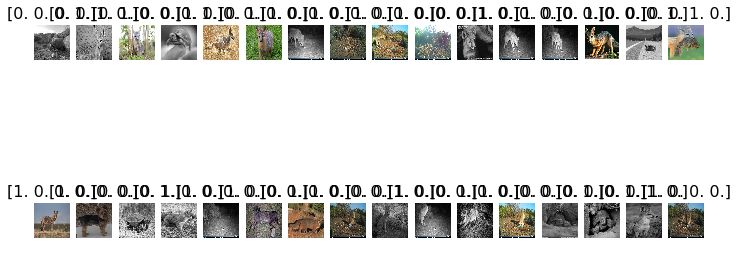

In [53]:

#assign test images to test batch and display
test_ims, test_labels = next(ftest_batches)
plots(test_ims, titles=test_labels)  


1/1 [==============================] - 0s 261ms/step
Confusion matrix, without normalization
[[6 3 3 3]
 [2 2 2 0]
 [3 2 0 0]
 [3 2 1 0]]


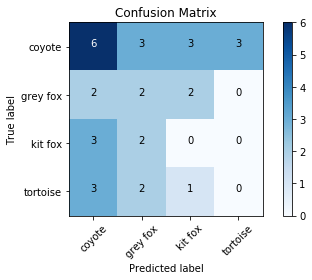

In [54]:

#create confusion matrix to display results
prediction = model.predict_generator(ftest_batches, steps=1, verbose=1)
cm = confusion_matrix(test_labels.argmax(axis=1), prediction.argmax(axis=1))
cm_plot_labels = ['coyote', 'grey fox','kit fox', 'tortoise']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [55]:

#crteate classification report to display results on test batch predictions
from sklearn.metrics import classification_report
y_true = test_labels.argmax(axis=1)
y_pred = prediction.argmax(axis=1)
target_names = ['coyote', 'grey fox','kit fox', 'tortoise']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      coyote       0.43      0.40      0.41        15
    grey fox       0.22      0.33      0.27         6
     kit fox       0.00      0.00      0.00         5
    tortoise       0.00      0.00      0.00         6

   micro avg       0.25      0.25      0.25        32
   macro avg       0.16      0.18      0.17        32
weighted avg       0.24      0.25      0.24        32



In [35]:
model.save_weights('test-re-train.h5')